In [40]:
import sys
sys.path.append('/home/cara/Documents/reddit_analysis_code')
import numpy as np
import pandas as pd
from reddit_dataclass import RedditData as reddit
import pickle
import matplotlib.pyplot as plt
import scipy.stats as scpstat
import matplotlib.dates as dates
import datetime
from sklearn import metrics
import statsmodels.formula.api as smf
import statsmodels.api as sm
from patsy import dmatrices

In [4]:
posts = pickle.load(open('thread_posts_EDT_times.p', 'rb'))

In [5]:
thread_info = pickle.load(open('thread_info.p', 'rb'))

In [6]:
new_posts = {}
for key in posts:
    new_posts[key] = posts[key]['all']

posts = new_posts

In [7]:
for key in thread_info:
    thread_info[key] = thread_info[key][['thread_id', 'thread_size', 'authors']]
thread_info['books']

,thread_id,thread_size,authors
0,xsgu8l,1,1
1,xsh6qv,1,1
2,xshdvl,1,1
3,xsi14p,1,1
4,xsis1h,1,1
...,...,...,...
4771,yhubu4,1,1
4772,yhufba,1,1
4773,yhukih,1,1
4774,yhumfc,1,1


In [8]:
regression_thread_data = {}
for key in thread_info:
    regression_thread_data[key] = pd.merge(
        thread_info[key], 
        posts[key][[
            'thread_id', 'timestamp', 'author',
            'subject_sentiment_score'
            ]],
        on='thread_id'
    )


# Logistic regression

In [9]:
for key in regression_thread_data:
    regression_thread_data[key]['success'] = 0
    regression_thread_data[key].loc[
        regression_thread_data[key].thread_size > 1, 'success'
    ] = 1

###books###
Optimization terminated successfully.
         Current function value: 0.630529
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                 4776
Model:                          Logit   Df Residuals:                     4774
Method:                           MLE   Df Model:                            1
Date:                Wed, 01 Feb 2023   Pseudo R-squ.:                0.001243
Time:                        16:14:50   Log-Likelihood:                -3011.4
converged:                       True   LL-Null:                       -3015.2
Covariance Type:            nonrobust   LLR p-value:                  0.006193
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -0.7072      0.032    -22.393      0.000   

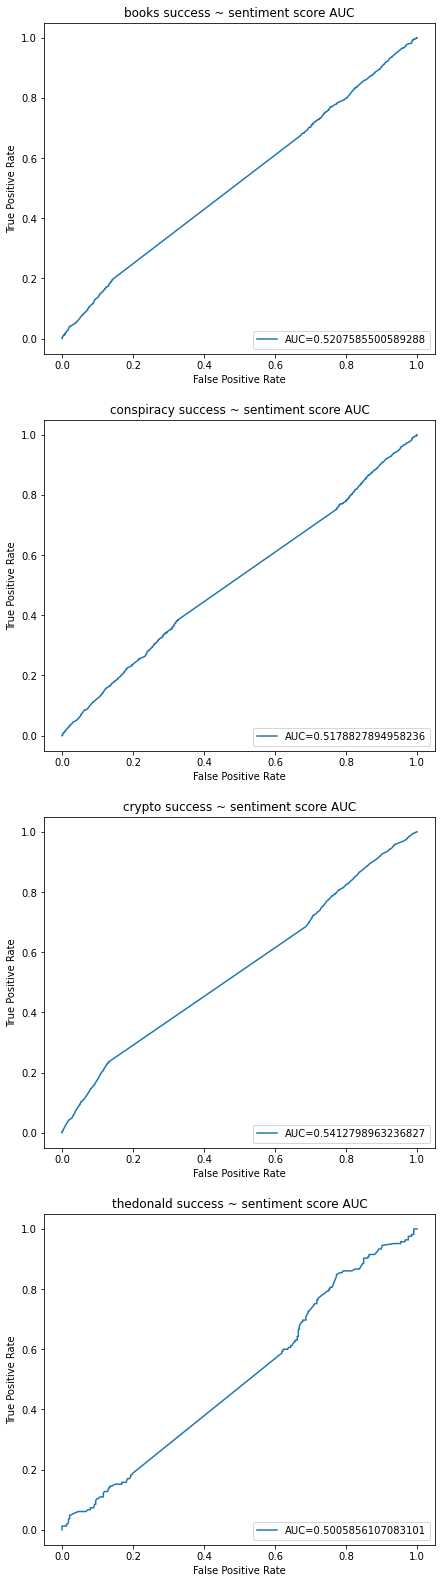

In [10]:
fig, axes = plt.subplots(4, figsize=(7,28))

i = 0

logistic_regression = {}

for key in regression_thread_data:
    print(f'###{key}###')
    logistic_regression[key] = smf.logit(
        "success ~ subject_sentiment_score",
        data=regression_thread_data[key]
    ).fit()
    print(logistic_regression[key].summary())

    y_predicted = logistic_regression[key].predict()
    y_real = regression_thread_data[key].success

    fpr, tpr, _ = metrics.roc_curve(y_real,  y_predicted)
    auc = metrics.roc_auc_score(y_real,  y_predicted)

    axes[i].plot(fpr, tpr, label="AUC="+str(auc))
    axes[i].set_ylabel('True Positive Rate')
    axes[i].set_xlabel('False Positive Rate')
    axes[i].set_title(f"{key} success ~ sentiment score AUC")
    axes[i].legend(loc=4)
    i += 1

plt.show()

    


# Linear regression

In [24]:
thread_size_cols = ['thread_id', 'thread_size', 'authors', 'subject_sentiment_score']
thread_size_data = {}
for key in regression_thread_data:
    thread_size_data[key] = regression_thread_data[key][thread_size_cols]
    for col in ['thread_size', 'authors']:
        thread_size_data[key][f'log_{col}'] = np.log(
            thread_size_data[key][col]
            )
    
    


/tmp/ipykernel_64404/1632681464.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thread_size_data[key][f'log_{col}'] = np.log(


array([[<AxesSubplot:title={'center':'log_authors'}>]], dtype=object)

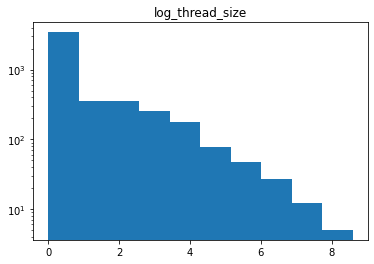

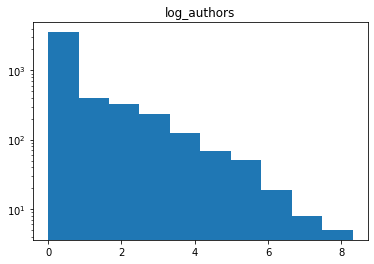

In [29]:


thread_size_data['books'].hist(column='log_thread_size', grid=False, log=True)
thread_size_data['books'].hist(column='log_authors', grid=False, log=True)

array([[<AxesSubplot:title={'center':'log_authors'}>]], dtype=object)

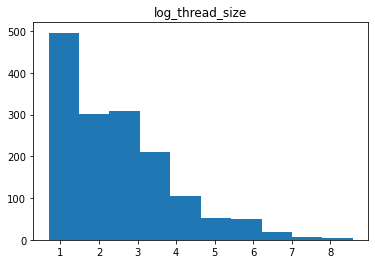

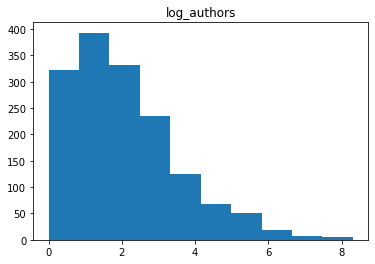

In [34]:
thread_size_data['books'][thread_size_data['books'].thread_size > 1].hist(column='log_thread_size', grid=False, log=False)
thread_size_data['books'][thread_size_data['books'].thread_size > 1].hist(column='log_authors', grid=False, log=False)

In [35]:

successful_thread_size_data = {}
for key in thread_size_data:
    successful_thread_size_data[key] = thread_size_data[key][
        thread_size_data[key].thread_size>  1
    ]

## Create design matrices
### For thread size

In [43]:
log_thread_size_X = {}
log_thread_size_y = {}
log_successful_thread_size_X = {}
log_successful_thread_size_y = {}
for key in thread_size_data:
    log_thread_size_y[key], log_thread_size_X[key] = (
        dmatrices(
            'log_thread_size ~ subject_sentiment_score',
            data=thread_size_data[key],
            return_type='dataframe'
        )
    )
    log_successful_thread_size_y[key], log_successful_thread_size_X[key] = (
        dmatrices(
            'log_thread_size ~ subject_sentiment_score',
            data=successful_thread_size_data[key],
            return_type='dataframe'
        )
    )

## OLS regression

In [45]:
thread_size_model = {}
successful_thread_size_model = {}
for key in log_thread_size_X:
    thread_size_model[key] = sm.OLS(log_thread_size_y[key], log_thread_size_X[key]).fit()
    successful_thread_size_model[key] = sm.OLS(log_successful_thread_size_y[key], log_successful_thread_size_X[key]).fit()
    

In [46]:
for key in thread_size_model:
    print(f'###{key}###')
    print('model = ALL, y = thread size, x = subject sentiment score')
    print(thread_size_model[key].summary())
    print('model = SUCCESS ONLY, y = thread size, x = subject sentiment score')
    print(successful_thread_size_model[key].summary())

###books###
model = ALL, y = thread size, x = subject sentiment score
                            OLS Regression Results                            
Dep. Variable:        log_thread_size   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     15.91
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           6.75e-05
Time:                        16:40:25   Log-Likelihood:                -8432.9
No. Observations:                4776   AIC:                         1.687e+04
Df Residuals:                    4774   BIC:                         1.688e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------

In [61]:
y

,log_thread_size
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
4771,0.0
4772,0.0
4773,0.0
4774,0.0


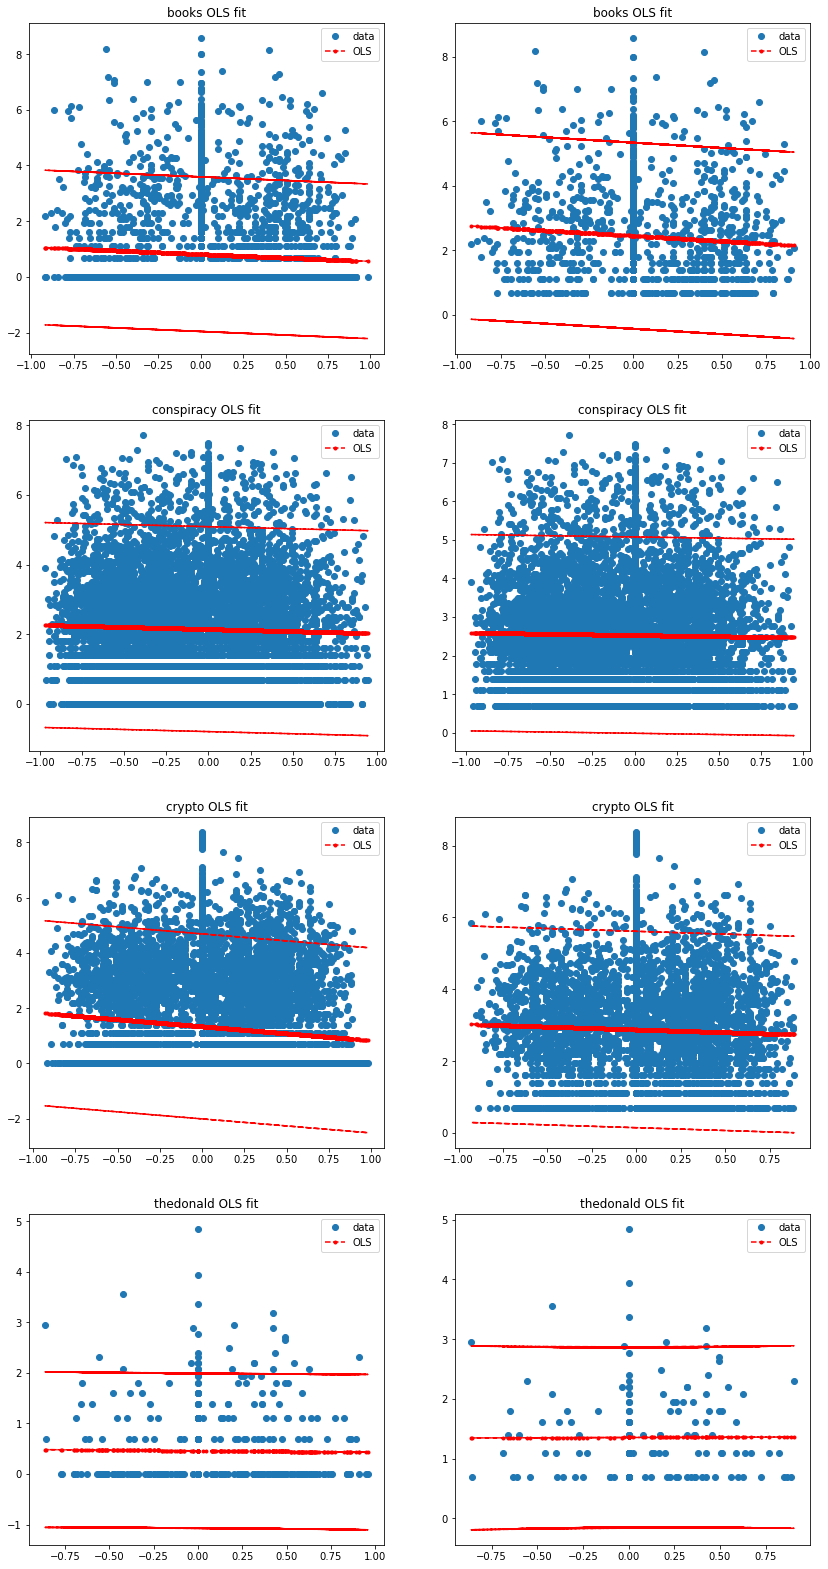

In [67]:
fig, axes = plt.subplots(4,2, figsize=(14, 28))

i = 0

for key in thread_size_model:
    pred_ols = thread_size_model[key].get_prediction()
    # conf intervals
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    x = log_thread_size_X[key].subject_sentiment_score
    y = log_thread_size_y[key].log_thread_size
    fitted_vals = thread_size_model[key].fittedvalues

    axes[i, 0].plot(x, y, "o", label="data")
    #axes[i, 0].plot(x, y_true, "b-", label="True")
    axes[i, 0].plot(x, fitted_vals, "r--.", label="OLS")
    axes[i, 0].plot(x, iv_u, "r--")
    axes[i, 0].plot(x, iv_l, "r--")
    axes[i, 0].legend(loc="best")
    axes[i, 0].set_title(f'{key} OLS fit')


    pred_ols = successful_thread_size_model[key].get_prediction()
    iv_l = pred_ols.summary_frame()["obs_ci_lower"]
    iv_u = pred_ols.summary_frame()["obs_ci_upper"]
    x = log_successful_thread_size_X[key].subject_sentiment_score
    y = log_successful_thread_size_y[key].log_thread_size
    fitted_vals = successful_thread_size_model[key].fittedvalues

    axes[i, 1].plot(x, y, "o", label="data")
    #axes[i,1].plot(x, y_true, "b-", label="True")
    axes[i, 1].plot(x, fitted_vals, "r--.", label="OLS")
    axes[i, 1].plot(x, iv_u, "r--")
    axes[i, 1].plot(x, iv_l, "r--")
    axes[i, 1].legend(loc="best")
    axes[i, 1].set_title(f'{key} OLS fit')

    i += 1
plt.show()

### Alternative without dmatrices step?

In [54]:
alt_mod = {}
for key in thread_size_data:
    alt_mod[key] = sm.OLS(
        thread_size_data[key].log_thread_size,
        thread_size_data[key].subject_sentiment_score
        ).fit()
    print(f'###{key}###\n\n{alt_mod[key].summary()}')

###books###

                                 OLS Regression Results                                
Dep. Variable:        log_thread_size   R-squared (uncentered):                   0.004
Model:                            OLS   Adj. R-squared (uncentered):              0.004
Method:                 Least Squares   F-statistic:                              20.56
Date:                Wed, 01 Feb 2023   Prob (F-statistic):                    5.92e-06
Time:                        17:44:06   Log-Likelihood:                         -9082.1
No. Observations:                4776   AIC:                                  1.817e+04
Df Residuals:                    4775   BIC:                                  1.817e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                              coef    std err          t      P>|t|      [0.025      0.975]
---------------

Different results so I think first one better

## GLS regression

In [55]:
GLS_thread_size_model = {}
GLS_successful_thread_size_model = {}
for key in log_thread_size_X:
    GLS_thread_size_model[key] = sm.GLS(log_thread_size_y[key], log_thread_size_X[key]).fit()
    GLS_successful_thread_size_model[key] = sm.GLS(log_successful_thread_size_y[key], log_successful_thread_size_X[key]).fit()

In [56]:
for key in GLS_thread_size_model:
    print(f'###{key}###')
    print('model = ALL, y = thread size, x = subject sentiment score')
    print(GLS_thread_size_model[key].summary())
    print('model = SUCCESS ONLY, y = thread size, x = subject sentiment score')
    print(GLS_successful_thread_size_model[key].summary())

###books###
model = ALL, y = thread size, x = subject sentiment score
                            GLS Regression Results                            
Dep. Variable:        log_thread_size   R-squared:                       0.003
Model:                            GLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     15.91
Date:                Wed, 01 Feb 2023   Prob (F-statistic):           6.75e-05
Time:                        17:47:48   Log-Likelihood:                -8432.9
No. Observations:                4776   AIC:                         1.687e+04
Df Residuals:                    4774   BIC:                         1.688e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------